In [1]:
#импорт библиотек
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F
from torchvision.utils import draw_bounding_boxes

from torchvision.io import read_image
import torchvision.transforms as transforms
from PIL import Image
import cv2


In [4]:
#загрузка и предобработка изображения
image = Image.open('examples/image.png') #загрузка
to_tensor = transforms.ToTensor() #задаем преобразование
image_trans = to_tensor(image) #применяем преобразование
print(image_trans.shape) #проверяем размерность - вместо 3-х каналов получили 4

print(image_trans[3]) #последний канал похож на маску

image_trans = image_trans[:3, :, :] #Избавимся от этого канала
print(image_trans.shape)

torch.Size([4, 886, 1300])
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])
torch.Size([3, 886, 1300])


In [5]:
#загружаем модель и веса
from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights #модель

weights = KeypointRCNN_ResNet50_FPN_Weights.DEFAULT #веса

In [6]:
model = keypointrcnn_resnet50_fpn(weights=weights, progress=False) #инициализация модели с нужными весами
model = model.eval() #переключение в режим инференса

outputs = model([image_trans]) #инференс
print(outputs)

Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to C:\Users\Asus-PC/.cache\torch\hub\checkpoints\keypointrcnn_resnet50_fpn_coco-fc266e95.pth


[{'boxes': tensor([[589.0520, 164.7326, 804.7424, 745.0168],
        [496.4900, 396.0956, 524.9801, 433.9450]], grad_fn=<StackBackward0>), 'labels': tensor([1, 1]), 'scores': tensor([0.9997, 0.1649], grad_fn=<IndexBackward0>), 'keypoints': tensor([[[724.5498, 228.4089,   1.0000],
         [736.7170, 218.4422,   1.0000],
         [715.7010, 217.3347,   1.0000],
         [751.0963, 226.1940,   1.0000],
         [700.2155, 218.4422,   1.0000],
         [762.1574, 287.1017,   1.0000],
         [665.9263, 285.9943,   1.0000],
         [795.3405, 319.2167,   1.0000],
         [639.3798, 363.5132,   1.0000],
         [778.7490, 381.2318,   1.0000],
         [700.2155, 334.7205,   1.0000],
         [720.1254, 447.6766,   1.0000],
         [661.5018, 445.4617,   1.0000],
         [676.9873, 567.2771,   1.0000],
         [685.8362, 567.2771,   1.0000],
         [631.6370, 682.4481,   1.0000],
         [748.8842, 578.3513,   1.0000]],

        [[515.6660, 402.0434,   1.0000],
         [517.8575, 

# отрисовка ключевых точек

In [8]:
#функция для отображения ключевых точек

def draw_keypoints_per_person(
    img, all_keypoints, all_scores, confs, keypoint_threshold=2, conf_threshold=0.9
):
    # создаём спектр цветов
    cmap = plt.get_cmap("rainbow")
    # создаём копию изображений
    img_copy = np.array(img)
    color_id = np.arange(1, 255, 255 // len(all_keypoints)).tolist()[::-1]
    # для каждого задетектированного человека
    for person_id in range(len(all_keypoints)):
        # проверяем степень уверенности детектора
        if confs[person_id] > conf_threshold:
            # собираем ключевые точки конкретного человека
            keypoints = all_keypoints[person_id, ...]
            # собираем скоры для ключевых точек
            scores = all_scores[person_id, ...]
            # итерируем по каждому скору
            for kp in range(len(scores)):
                # проверяем степень уверенности детектора опорной точки
                if scores[kp] > keypoint_threshold:
                    # конвертируем массив ключевых точек в список целых чисел
                    keypoint = tuple(
                        map(int, keypoints[kp, :2].detach().numpy().tolist())
                    )
                    # выбираем цвет
                    color = tuple(np.asarray(cmap(color_id[person_id])[:-1]) * 255)
                    # рисуем кружок радиуса 5 вокруг точки
                    cv2.circle(img_copy, keypoint, 5, color, -1)

    return img_copy

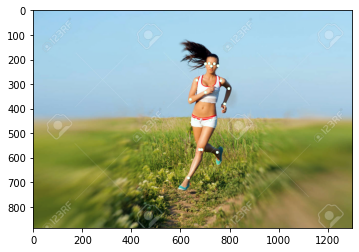

In [9]:
#отрисовка ключевых точек
all_keypoints, all_scores, confs = outputs[0]['keypoints'], outputs[0]['keypoints_scores'], outputs[0]['scores']

plt.imshow(draw_keypoints_per_person(image, all_keypoints, all_scores, confs))



# отрисовка каркаса

In [10]:
#создадим список опорных точек
keypoints_list = ['nose','left_eye','right_eye',\
'left_ear','right_ear','left_shoulder',\
'right_shoulder','left_elbow','right_elbow',\
'left_wrist','right_wrist','left_hip',\
'right_hip','left_knee', 'right_knee', \
'left_ankle','right_ankle']

In [11]:
#создадим список "конечностей"
def get_limbs_from_keypoints(keypoints):
    limbs = [
        [keypoints.index("right_eye"), keypoints.index("nose")],
        [keypoints.index("right_eye"), keypoints.index("right_ear")],
        [keypoints.index("left_eye"), keypoints.index("nose")],
        [keypoints.index("left_eye"), keypoints.index("left_ear")],
        [keypoints.index("right_shoulder"), keypoints.index("right_elbow")],
        [keypoints.index("right_elbow"), keypoints.index("right_wrist")],
        [keypoints.index("left_shoulder"), keypoints.index("left_elbow")],
        [keypoints.index("left_elbow"), keypoints.index("left_wrist")],
        [keypoints.index("right_hip"), keypoints.index("right_knee")],
        [keypoints.index("right_knee"), keypoints.index("right_ankle")],
        [keypoints.index("left_hip"), keypoints.index("left_knee")],
        [keypoints.index("left_knee"), keypoints.index("left_ankle")],
        [keypoints.index("right_shoulder"), keypoints.index("left_shoulder")],
        [keypoints.index("right_hip"), keypoints.index("left_hip")],
        [keypoints.index("right_shoulder"), keypoints.index("right_hip")],
        [keypoints.index("left_shoulder"), keypoints.index("left_hip")],
    ]
    return limbs


limbs = get_limbs_from_keypoints(keypoints_list)
print(limbs)

[[2, 0], [2, 4], [1, 0], [1, 3], [6, 8], [8, 10], [5, 7], [7, 9], [12, 14], [14, 16], [11, 13], [13, 15], [6, 5], [12, 11], [6, 12], [5, 11]]


In [12]:
#функция для отрисовки каркаса

def draw_keleton_per_person(
    img, all_keypoints, all_scores, confs, limbs, keypoint_threshold=2, conf_threshold=0.9
):
    # создаём спектр цветов
    cmap = plt.get_cmap("rainbow")
    # создаём копию изображений
    img_copy = np.array(img)
    color_id = np.arange(1, 255, 255 // len(all_keypoints)).tolist()[::-1]
    # для каждого задетектированного человека
    for person_id in range(len(all_keypoints)):
        # проверяем степень уверенности детектора
        if confs[person_id] > conf_threshold:
            # собираем ключевые точки конкретного человека
            keypoints = all_keypoints[person_id, ...]
            kp_list = []
            # собираем скоры для ключевых точек
            scores = all_scores[person_id, ...]
            # итерируем по каждому скору
            for kp in range(len(scores)):
                # проверяем степень уверенности детектора опорной точки
                if scores[kp] > keypoint_threshold:
                    # конвертируем массив ключевых точек в список целых чисел
                    keypoint = tuple(
                        map(int, keypoints[kp, :2].detach().numpy().tolist())
                    )
                    kp_list.append(keypoint)
                    # выбираем цвет
                    color = tuple(np.asarray(cmap(color_id[person_id])[:-1]) * 255)
                    # рисуем кружок радиуса 5 вокруг точки
                    cv2.circle(img_copy, keypoint, 5, color, -1)
            print(kp_list)
            for limb in limbs:
                cv2.line(img_copy, kp_list[limb[0]], kp_list[limb[1]], color, 2)
    return img_copy

[(724, 228), (736, 218), (715, 217), (751, 226), (700, 218), (762, 287), (665, 285), (795, 319), (639, 363), (778, 381), (700, 334), (720, 447), (661, 445), (676, 567), (685, 567), (631, 682), (748, 578)]


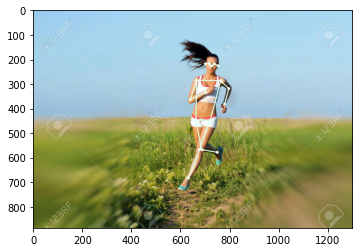

In [13]:
#отрисовка каркаса
all_keypoints, all_scores, confs = outputs[0]['keypoints'], outputs[0]['keypoints_scores'], outputs[0]['scores']

plt.imshow(draw_keleton_per_person(image, all_keypoints, all_scores, confs, limbs))